# Synthetic Financial Datasets for Fraud Detection
## (Synthetic datsets generated by the PaySim mobile money simulator)

### MetaData:

Information about features

* `step` - maps a unit of time in the real world. In this case 1 step is 1 hour of time. Total steps 744 (30 days simulation).

* `type` - CASH-IN, CASH-OUT, DEBIT, PAYMENT and TRANSFER.

* `amount` - amount of the transaction in local currency.

* `nameOrig` - customer who started the transaction

* `oldbalanceOrg` - initial balance before the transaction

* `newbalanceOrig` - new balance after the transaction

* `nameDest` - customer who is the recipient of the transaction

* `oldbalanceDest` - initial balance recipient before the transaction. Note that there is not information for customers that start with M (Merchants).

* `newbalanceDest` - new balance recipient after the transaction. Note that there is not information for customers that start with M (Merchants).

* `isFraud` - This is the transactions made by the fraudulent agents inside the simulation. In this specific dataset the fraudulent behavior of the agents aims to profit by taking control or customers accounts and try to empty the funds by transferring to another account and then cashing out of the system.

* `isFlaggedFraud` - The business model aims to control massive transfers from one account to another and flags illegal attempts. An illegal attempt in this dataset is an attempt to transfer more than 200.000 in a single transaction.

In [1]:
# Import all the required libraries

import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

from sklearn.svm import SVC
from sklearn import preprocessing
from scipy.stats import skew, boxcox

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
import plotly.express as px
import plotly.graph_objs as go

In [2]:
# Loading dataset into the dataframe
df = pd.read_csv('PS_20174392719_1491204439457_log.csv')

In [3]:
df.dtypes

step                int64
type               object
amount            float64
nameOrig           object
oldbalanceOrg     float64
newbalanceOrig    float64
nameDest           object
oldbalanceDest    float64
newbalanceDest    float64
isFraud             int64
isFlaggedFraud      int64
dtype: object

* As we can see there are float and int datatype in most of the features and remaining some of features has object type.

In [4]:
df.shape

(6362620, 11)

* As above figures shows that we have very good amount of dataset size to train our model.
* We have `6362620` number of rows and `11` coulmns (features).

In [5]:
df.isnull().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

* As we can see there is no missing values present in the dataset. It is already pre-processed.

In [6]:
df.duplicated().sum()

0

* As we can see there is no duplicate value present in the dataset. It is already pre-processed.

In [7]:
df

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.00,160296.36,M1979787155,0.00,0.00,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.00,19384.72,M2044282225,0.00,0.00,0,0
2,1,TRANSFER,181.00,C1305486145,181.00,0.00,C553264065,0.00,0.00,1,0
3,1,CASH_OUT,181.00,C840083671,181.00,0.00,C38997010,21182.00,0.00,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.00,29885.86,M1230701703,0.00,0.00,0,0
...,...,...,...,...,...,...,...,...,...,...,...
6362615,743,CASH_OUT,339682.13,C786484425,339682.13,0.00,C776919290,0.00,339682.13,1,0
6362616,743,TRANSFER,6311409.28,C1529008245,6311409.28,0.00,C1881841831,0.00,0.00,1,0
6362617,743,CASH_OUT,6311409.28,C1162922333,6311409.28,0.00,C1365125890,68488.84,6379898.11,1,0
6362618,743,TRANSFER,850002.52,C1685995037,850002.52,0.00,C2080388513,0.00,0.00,1,0


# EDA (Exploratory Data Analysis) 

In [8]:
df.describe()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
count,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06
mean,2.433972e+02,1.798619e+05,8.338831e+05,8.551137e+05,1.100702e+06,1.224996e+06,1.290820e-03,2.514687e-06
std,1.423320e+02,6.038582e+05,2.888243e+06,2.924049e+06,3.399180e+06,3.674129e+06,3.590480e-02,1.585775e-03
min,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.560000e+02,1.338957e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.390000e+02,7.487194e+04,1.420800e+04,0.000000e+00,1.327057e+05,2.146614e+05,0.000000e+00,0.000000e+00
75%,3.350000e+02,2.087215e+05,1.073152e+05,1.442584e+05,9.430367e+05,1.111909e+06,0.000000e+00,0.000000e+00
max,7.430000e+02,9.244552e+07,5.958504e+07,4.958504e+07,3.560159e+08,3.561793e+08,1.000000e+00,1.000000e+00


* Here is the mathematical calculations and values for the numeric datatype fields in dataset.

CASH_OUT    2237500
PAYMENT     2151495
CASH_IN     1399284
TRANSFER     532909
DEBIT         41432
Name: type, dtype: int64


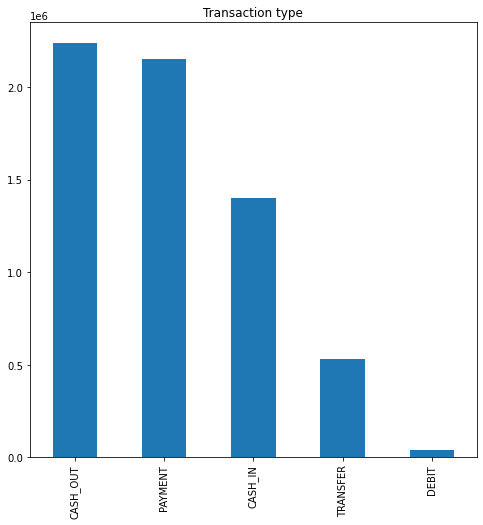

In [9]:
print(df.type.value_counts())

f, ax = plt.subplots(1, 1, figsize=(8, 8))
df.type.value_counts().plot(kind='bar', title="Transaction type", ax=ax, figsize=(8,8))
plt.show()

* There are 2 flags which stand out to me and it's interesting to look onto: isFraud and isFlaggedFraud column.
* From the hypothesis, isFraud is the indicator which indicates the actual fraud transactions whereas isFlaggedFraud is what the system prevents the transaction due to some thresholds being triggered.

* Let's quickly what kinds of transaction are being flagged and are fraud...

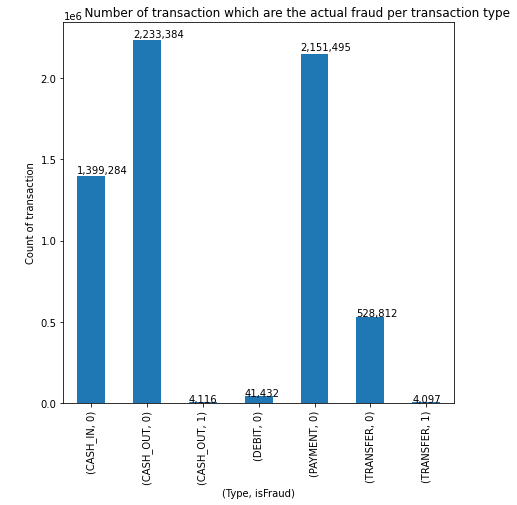

In [10]:
ax = df.groupby(['type', 'isFraud']).size().plot(kind='bar',figsize=(7,7))
ax.set_title("                    Number of transaction which are the actual fraud per transaction type")
ax.set_xlabel("(Type, isFraud)")
ax.set_ylabel("Count of transaction")
for p in ax.patches:
    ax.annotate(str(format(int(p.get_height()), ',d')), (p.get_x(), p.get_height()*1.01))

* From the above graph we can see that there are only two categories in transaction type which contains fraud transactions.
* We can conclude that to train model wee only required this two categorical records only to predict whether it is a fraud or valid transection.

In [11]:
print('\nThe type of transactions in which isFlaggedFraud is set: \
{}'.format(list(df.loc[df.isFlaggedFraud == 1].type.drop_duplicates()))) 
                                                            # only 'TRANSFER'

dfTransfer = df.loc[df.type == 'TRANSFER']
dfFlagged = df.loc[df.isFlaggedFraud == 1]
dfNotFlagged = df.loc[df.isFlaggedFraud == 0]

print('\nMin amount transacted when isFlaggedFraud is set= {}'\
                                  .format(dfFlagged.amount.min())) # 353874.22

print('\nMax amount transacted in a TRANSFER where isFlaggedFraud is not set=\
 {}'.format(dfTransfer.loc[dfTransfer.isFlaggedFraud == 0].amount.max())) # 92445516.64


The type of transactions in which isFlaggedFraud is set: ['TRANSFER']

Min amount transacted when isFlaggedFraud is set= 353874.22

Max amount transacted in a TRANSFER where isFlaggedFraud is not set= 92445516.64


* Can oldBalanceDest and newBalanceDest determine isFlaggedFraud being set?
* The old is identical to the new balance in the origin and destination accounts, for every TRANSFER where isFlaggedFraud is set.
* This is presumably because the transaction is halted.
* Interestingly, oldBalanceDest = 0 in every such transaction. 
* However, as shown below, since isFlaggedFraud can remain not set in TRANSFERS where oldBalanceDest and newBalanceDest can both be 0, these conditions do not determine the state of isFlaggedFraud.

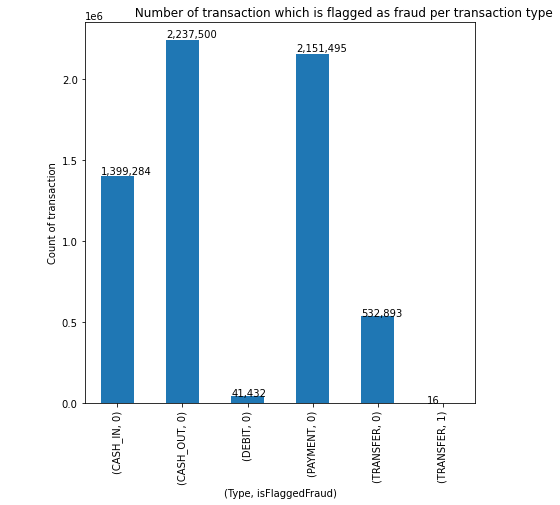

In [12]:
ax = df.groupby(['type', 'isFlaggedFraud']).size().plot(kind='bar',figsize=(7,7))
ax.set_title("                                 Number of transaction which is flagged as fraud per transaction type")
ax.set_xlabel("(Type, isFlaggedFraud)")
ax.set_ylabel("Count of transaction")
for p in ax.patches:
    ax.annotate(str(format(int(p.get_height()), ',d')), (p.get_x(), p.get_height()*1.01))

* So it looks the simulation can flag only 16 transfer transactions as fraud. Let's look at those records and compare with the records which the system cannot catch'em.

* The plot below will also focus only on transfer transaction type.

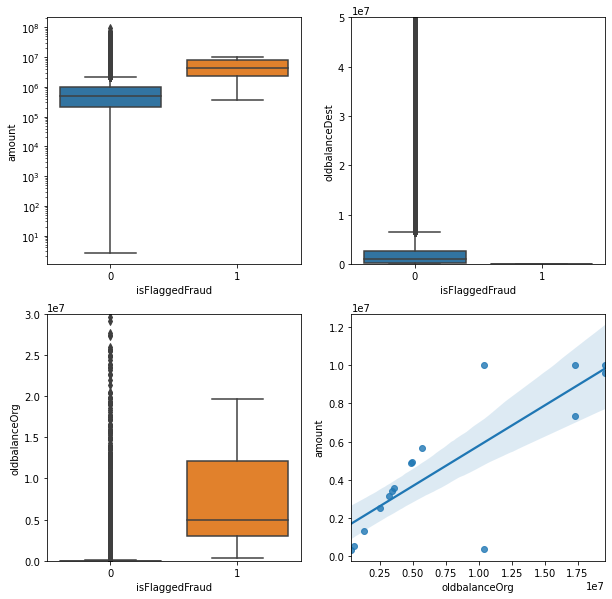

In [13]:
fig, axs = plt.subplots(2, 2, figsize=(10, 10))
tmp = df.loc[(df.type == 'TRANSFER'), :]

a = sns.boxplot(x = 'isFlaggedFraud', y = 'amount', data = tmp, ax=axs[0][0])
axs[0][0].set_yscale('log')
b = sns.boxplot(x = 'isFlaggedFraud', y = 'oldbalanceDest', data = tmp, ax=axs[0][1])
axs[0][1].set(ylim=(0, 0.5e8))
c = sns.boxplot(x = 'isFlaggedFraud', y = 'oldbalanceOrg', data=tmp, ax=axs[1][0])
axs[1][0].set(ylim=(0, 3e7))
d = sns.regplot(x = 'oldbalanceOrg', y = 'amount', data=tmp.loc[(tmp.isFlaggedFraud ==1), :], ax=axs[1][1])
plt.show()


* It looks like isFlaggedFraud variable is relied on oldbalanceDest, which is 0 and some threshold on the amount variable.

In [14]:
df.groupby(['type', 'isFraud']).count()['step']

type      isFraud
CASH_IN   0          1399284
CASH_OUT  0          2233384
          1             4116
DEBIT     0            41432
PAYMENT   0          2151495
TRANSFER  0           528812
          1             4097
Name: step, dtype: int64

* By looking at the type of transaction, let's calculate the number of frauds for each of these categories. We can do that simply by grouping on the type and fraud indicator and counting the rows.

* Interesting to see here is, that there are only fraudulent activities for CASH_OUT and TRANSFER type.

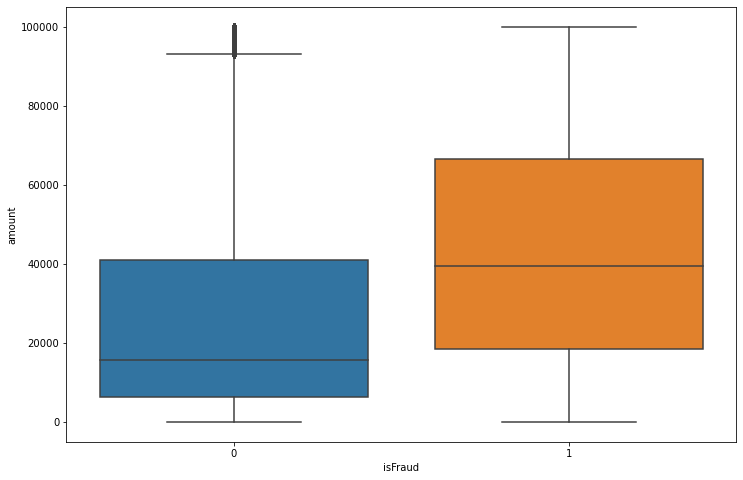

In [15]:
plt.figure(figsize=(12,8))
sns.boxplot(x = 'isFraud', y = 'amount', data = df[df.amount < 1e5])

* By looking at boxplots for amount, fraudulent activities tend to have larger amounts.

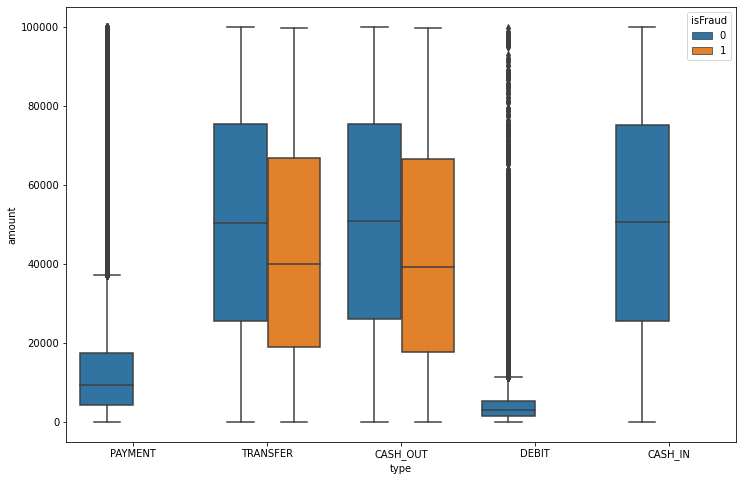

In [16]:
plt.figure(figsize=(12,8))
sns.boxplot(hue = 'isFraud', x = 'type', y = 'amount', data = df[df.amount < 1e5])

* There are only fraudulent activities for CASH_OUT and TRANSFER type

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


In [18]:
df.drop(['nameOrig','nameDest','isFlaggedFraud'], axis = 1) 

,step,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud
0,1,PAYMENT,9839.64,170136.00,160296.36,0.00,0.00,0
1,1,PAYMENT,1864.28,21249.00,19384.72,0.00,0.00,0
2,1,TRANSFER,181.00,181.00,0.00,0.00,0.00,1
3,1,CASH_OUT,181.00,181.00,0.00,21182.00,0.00,1
4,1,PAYMENT,11668.14,41554.00,29885.86,0.00,0.00,0
...,...,...,...,...,...,...,...,...
6362615,743,CASH_OUT,339682.13,339682.13,0.00,0.00,339682.13,1
6362616,743,TRANSFER,6311409.28,6311409.28,0.00,0.00,0.00,1
6362617,743,CASH_OUT,6311409.28,6311409.28,0.00,68488.84,6379898.11,1
6362618,743,TRANSFER,850002.52,850002.52,0.00,0.00,0.00,1


Here we are removing two object datatype columns `isFlaggedFraud`, `nameOrig` and `nameDest` because it has unique values and not having relation with fraud transactions.

In [19]:
def Convert_to_Num(df):
    type = df["type"].unique()
    type.sort()
    type = dict(zip(type, range(len(type))))
    df.type.replace(type, inplace=True)
    print(type)    
    
Convert_to_Num(df)

{'CASH_IN': 0, 'CASH_OUT': 1, 'DEBIT': 2, 'PAYMENT': 3, 'TRANSFER': 4}


* From the above block of code we have transform categorical data into the integers.

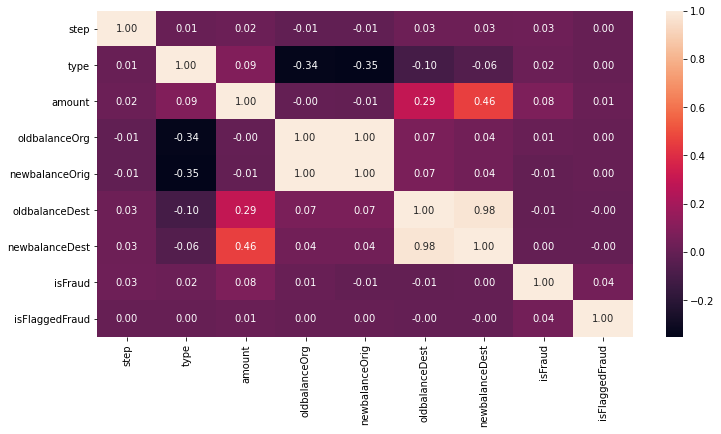

In [20]:
# Explore correlations visually
f, ax = plt.subplots(figsize=(12,6))
sns.heatmap(df.corr(), annot=True, fmt='.2f')

* here is the correlation heatmap to see the relation between features and target variables.

Quickly get the count and the target variable count.

* Let's create new dataframe with only the `CASH_OUT` and `TRANSFER` type.

In [21]:
from statsmodels.tools import categorical

df = pd.read_csv('PS_20174392719_1491204439457_log.csv')
# 1. Keep only interested transaction type ('TRANSFER', 'CASH_OUT')
# 2. Drop some columns
# 3. Convert categorical variables to numeric variable
tmp = df.loc[(df['type'].isin(['TRANSFER', 'CASH_OUT'])),:]
tmp.drop(['step', 'nameOrig', 'nameDest', 'isFlaggedFraud'], axis=1, inplace=True)
tmp = tmp.reset_index(drop=True)
a = np.array(tmp['type'])
b = categorical(a, drop=True)
tmp['type_num'] = b.argmax(1)

tmp.head(3)


C:\Users\harsh\anaconda3\lib\site-packages\pandas\core\frame.py:3990: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,type_num
0,TRANSFER,181.00,181.0,0.0,0.0,0.00,1,1
1,CASH_OUT,181.00,181.0,0.0,21182.0,0.00,1,0
2,CASH_OUT,229133.94,15325.0,0.0,5083.0,51513.44,0,0


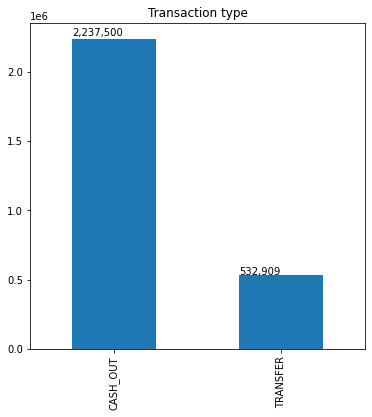

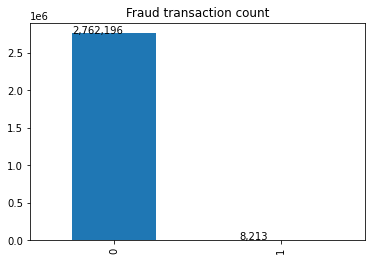

In [22]:
ax = tmp.type.value_counts().plot(kind='bar', title="Transaction type", figsize=(6,6))
for p in ax.patches:
    ax.annotate(str(format(int(p.get_height()), ',d')), (p.get_x(), p.get_height()*1.01))

plt.show()

ax = pd.value_counts(tmp['isFraud'], sort = True).sort_index().plot(kind='bar', title="Fraud transaction count")
for p in ax.patches:
    ax.annotate(str(format(int(p.get_height()), ',d')), (p.get_x(), p.get_height()))
    
plt.show()

* From the above graphs we can see that our given dataset is highly imbalanced dataset.
* We only have `8213` fraud transections and `2762196` normal transaction for only two categorical transection cashout and transfer.
* Here the ration of having fraud transaction compared to normal transaction is very very low.
* And compared to original dataset we have `6.5` million transections and compared to that this fraud transections are nothing in the ratio.
* we are required to first balance our dataset then and only then we can train any classification model on it. otherwise this existing biased dataset will predict evey every transection as normal transaction.
* To resolve this unbalanced dataset we have to create one small balanced data sample for traing models.

### Let's normalize the data and treate the outliers 

* This processing of data is highly needed to get prepared the data for training the model.

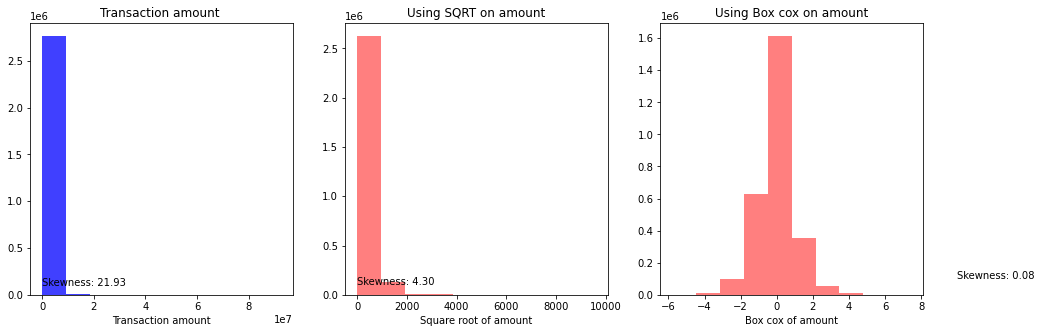

In [23]:
tmp['amount_boxcox'] = preprocessing.scale(boxcox(tmp['amount']+1)[0])

figure = plt.figure(figsize=(16, 5))
figure.add_subplot(131) 
plt.hist(tmp['amount'] ,facecolor='blue',alpha=0.75) 
plt.xlabel("Transaction amount") 
plt.title("Transaction amount ") 
plt.text(10,100000,"Skewness: {0:.2f}".format(skew(tmp['amount'])))

figure.add_subplot(132)
plt.hist(np.sqrt(tmp['amount']), facecolor = 'red', alpha=0.5)
plt.xlabel("Square root of amount")
plt.title("Using SQRT on amount")
plt.text(10, 100000, "Skewness: {0:.2f}".format(skew(np.sqrt(tmp['amount']))))

figure.add_subplot(133)
plt.hist(tmp['amount_boxcox'], facecolor = 'red', alpha=0.5)
plt.xlabel("Box cox of amount")
plt.title("Using Box cox on amount")
plt.text(10, 100000, "Skewness: {0:.2f}".format(skew(tmp['amount_boxcox'])))

plt.show()

* I have used Box cox method to normalize data. 
* from the SQRT normalization and Box cox normalization graph we clearly see that box cox tranformation is very effective to normalize data.

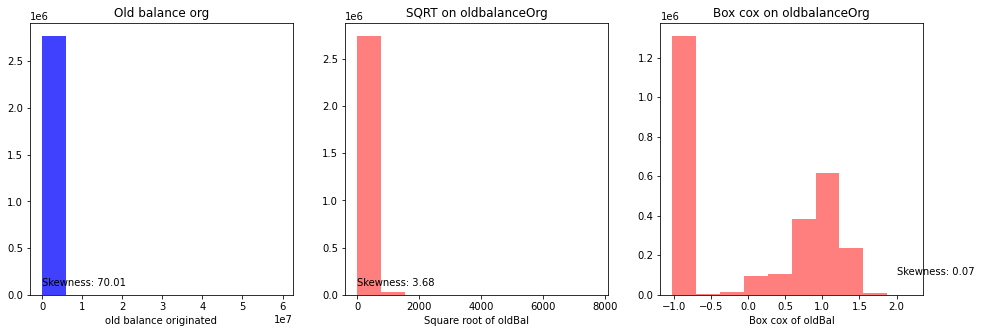

In [24]:
tmp['oldbalanceOrg_boxcox'] = preprocessing.scale(boxcox(tmp['oldbalanceOrg']+1)[0])

figure = plt.figure(figsize=(16, 5))
figure.add_subplot(131) 
plt.hist(tmp['oldbalanceOrg'] ,facecolor='blue',alpha=0.75) 
plt.xlabel("old balance originated") 
plt.title("Old balance org") 
plt.text(2,100000,"Skewness: {0:.2f}".format(skew(tmp['oldbalanceOrg'])))


figure.add_subplot(132)
plt.hist(np.sqrt(tmp['oldbalanceOrg']), facecolor = 'red', alpha=0.5)
plt.xlabel("Square root of oldBal")
plt.title("SQRT on oldbalanceOrg")
plt.text(2, 100000, "Skewness: {0:.2f}".format(skew(np.sqrt(tmp['oldbalanceOrg']))))

figure.add_subplot(133)
plt.hist(tmp['oldbalanceOrg_boxcox'], facecolor = 'red', alpha=0.5)
plt.xlabel("Box cox of oldBal")
plt.title("Box cox on oldbalanceOrg")
plt.text(2, 100000, "Skewness: {0:.2f}".format(skew(tmp['oldbalanceOrg_boxcox'])))

plt.show()

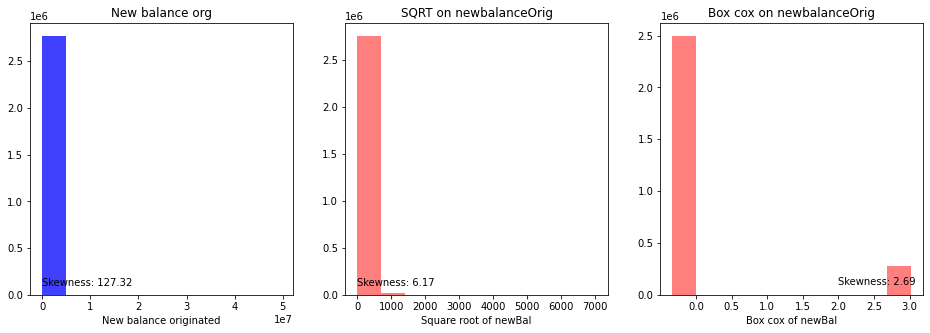

In [25]:
tmp['newbalanceOrg_boxcox'] = preprocessing.scale(boxcox(tmp['newbalanceOrig']+1)[0])

figure = plt.figure(figsize=(16, 5))
figure.add_subplot(131) 
plt.hist(tmp['newbalanceOrig'] ,facecolor='blue',alpha=0.75) 
plt.xlabel("New balance originated") 
plt.title("New balance org") 
plt.text(2,100000,"Skewness: {0:.2f}".format(skew(tmp['newbalanceOrig'])))


figure.add_subplot(132)
plt.hist(np.sqrt(tmp['newbalanceOrig']), facecolor = 'red', alpha=0.5)
plt.xlabel("Square root of newBal")
plt.title("SQRT on newbalanceOrig")
plt.text(2, 100000, "Skewness: {0:.2f}".format(skew(np.sqrt(tmp['newbalanceOrig']))))

figure.add_subplot(133)
plt.hist(tmp['newbalanceOrg_boxcox'], facecolor = 'red', alpha=0.5)
plt.xlabel("Box cox of newBal")
plt.title("Box cox on newbalanceOrig")
plt.text(2, 100000, "Skewness: {0:.2f}".format(skew(tmp['newbalanceOrg_boxcox'])))

plt.show()

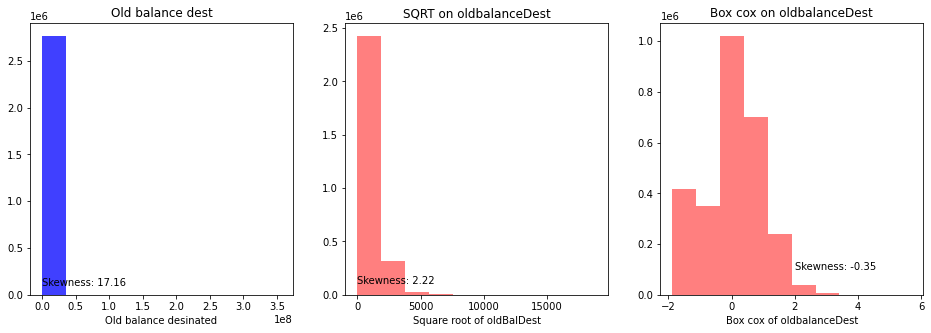

In [26]:
tmp['oldbalanceDest_boxcox'] = preprocessing.scale(boxcox(tmp['oldbalanceDest']+1)[0])

figure = plt.figure(figsize=(16, 5))
figure.add_subplot(131) 
plt.hist(tmp['oldbalanceDest'] ,facecolor='blue',alpha=0.75) 
plt.xlabel("Old balance desinated") 
plt.title("Old balance dest") 
plt.text(2,100000,"Skewness: {0:.2f}".format(skew(tmp['oldbalanceDest'])))


figure.add_subplot(132)
plt.hist(np.sqrt(tmp['oldbalanceDest']), facecolor = 'red', alpha=0.5)
plt.xlabel("Square root of oldBalDest")
plt.title("SQRT on oldbalanceDest")
plt.text(2, 100000, "Skewness: {0:.2f}".format(skew(np.sqrt(tmp['oldbalanceDest']))))

figure.add_subplot(133)
plt.hist(tmp['oldbalanceDest_boxcox'], facecolor = 'red', alpha=0.5)
plt.xlabel("Box cox of oldbalanceDest")
plt.title("Box cox on oldbalanceDest")
plt.text(2, 100000, "Skewness: {0:.2f}".format(skew(tmp['oldbalanceDest_boxcox'])))

plt.show()

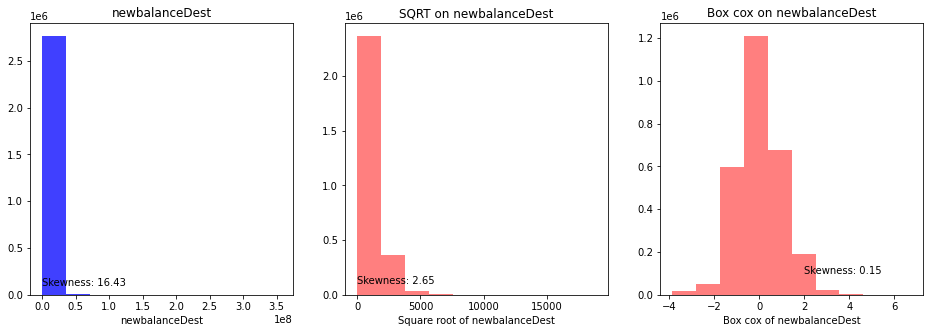

In [27]:
tmp['newbalanceDest_boxcox'] = preprocessing.scale(boxcox(tmp['newbalanceDest']+1)[0])

figure = plt.figure(figsize=(16, 5))
figure.add_subplot(131) 
plt.hist(tmp['newbalanceDest'] ,facecolor='blue',alpha=0.75) 
plt.xlabel("newbalanceDest") 
plt.title("newbalanceDest") 
plt.text(2,100000,"Skewness: {0:.2f}".format(skew(tmp['newbalanceDest'])))


figure.add_subplot(132)
plt.hist(np.sqrt(tmp['newbalanceDest']), facecolor = 'red', alpha=0.5)
plt.xlabel("Square root of newbalanceDest")
plt.title("SQRT on newbalanceDest")
plt.text(2, 100000, "Skewness: {0:.2f}".format(skew(np.sqrt(tmp['newbalanceDest']))))

figure.add_subplot(133)
plt.hist(tmp['newbalanceDest_boxcox'], facecolor = 'red', alpha=0.5)
plt.xlabel("Box cox of newbalanceDest")
plt.title("Box cox on newbalanceDest")
plt.text(2, 100000, "Skewness: {0:.2f}".format(skew(tmp['newbalanceDest_boxcox'])))

plt.show()

* we have apply on all the required columns the box cox transformation and created the modify version of exsisting dataset.

In [28]:
print("The fraud transaction of the filtered dataset: {0:.4f}%".format((len(tmp[tmp.isFraud == 1])/len(tmp)) * 100))

The fraud transaction of the filtered dataset: 0.2965%


In [29]:
tmp.drop(['oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest', 'amount', 'type'], axis=1, inplace=True)

y = tmp["isFraud"]
X = tmp.drop(["isFraud"], axis = 1)

In [30]:
# Number of data points in the minority class
number_records_fraud = len(tmp[tmp.isFraud == 1])
fraud_indices = tmp[tmp.isFraud == 1].index.values

# Picking the indices of the normal classes
normal_indices = tmp[tmp.isFraud == 0].index

# Out of the indices we picked, randomly select "x" number (x - same as total fraud)
random_normal_indices = np.random.choice(normal_indices, number_records_fraud, replace = False)
random_normal_indices = np.array(random_normal_indices)

# Appending the 2 indices
under_sample_indices = np.concatenate([fraud_indices,random_normal_indices])
under_sample_data = tmp.iloc[under_sample_indices, :]

X_undersample = under_sample_data.drop(['isFraud'], axis=1)
y_undersample = under_sample_data['isFraud']


# Showing ratio
print("Percentage of normal transactions: ", len(under_sample_data[under_sample_data.isFraud == 0])/len(under_sample_data))
print("Percentage of fraud transactions: ", len(under_sample_data[under_sample_data.isFraud == 1])/len(under_sample_data))
print("Total number of transactions in resampled data: ", len(under_sample_data))

Percentage of normal transactions:  0.5
Percentage of fraud transactions:  0.5
Total number of transactions in resampled data:  16426


* so here we have balanced our dataset with exactly the equal number of fraud transections and normal transections.
* So we have now our balanced sample dataset ready for the training model on it.
* the sample dataset contains total `16426` number of transection.

## Outliers :Let's check for the outliers in the sample dataset we have created for training a model.

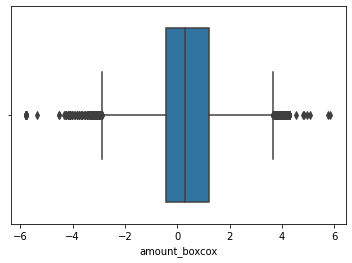

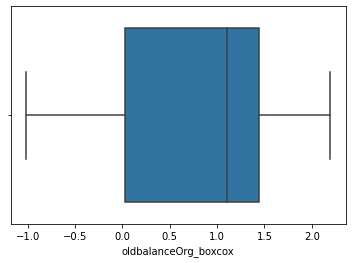

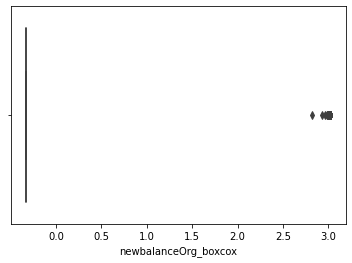

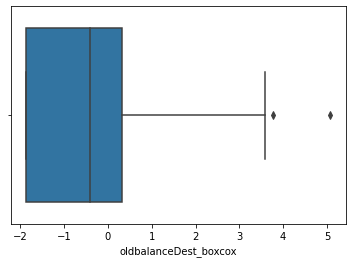

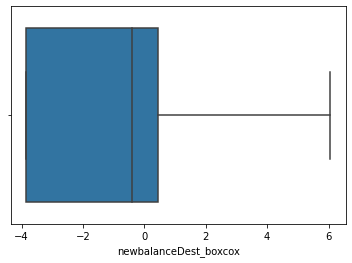

In [31]:
# List of columns names with contineous values
col = ['amount_boxcox','oldbalanceOrg_boxcox', 'newbalanceOrg_boxcox', 'oldbalanceDest_boxcox', 'newbalanceDest_boxcox']

# To find outliers
for i in col:
    sns.boxplot(X_undersample[i])
    plt.show()

* So mostly there are no outliers after normalizing data. there are a few we can see let's use IQR method to treat outliers.
* If the data falls outside of IQR then remove them.

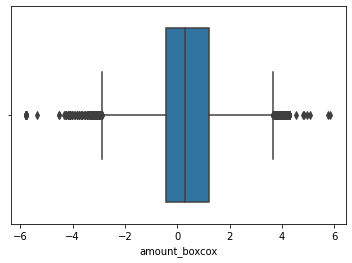

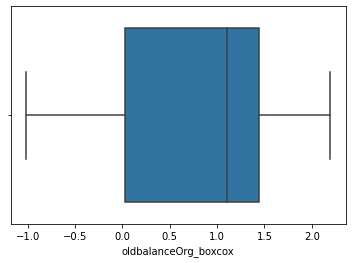

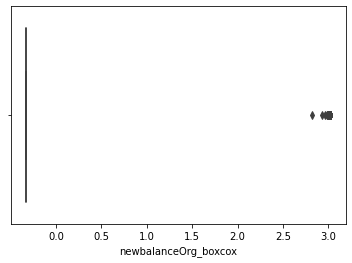

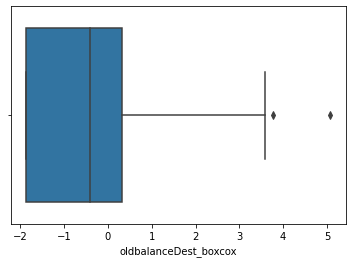

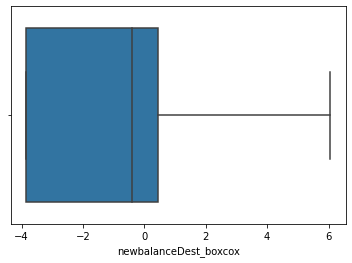

In [32]:
# Making a copy of the clean dataframe
df1 = X_undersample.copy()

# To remove outliers
for i in col:
    q1 = df1[i].quantile(q=0.25)
    q2 = df1[i].quantile()
    q3 = df1[i].quantile(q=0.75)
    iqr = q3-q1
    ul = q3+1.5*iqr
    ll = q1-1.5*iqr

    #df1 = df1[(df1[i]<ul ) & (df1[i]>ll)] 

# To find outliers
for i in col:
    sns.boxplot(df1[i])
    plt.show()

* As we can see, all the outliers are handled and there is perfectly fine dataset. All the data points are in the IQR range.
* Now we can use it to train model.

## Let's split the dataset and build the model

In [33]:
# Whole dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)

print("Number transactions train dataset: ", format(len(X_train),',d'))
print("Number transactions test dataset: ", format(len(X_test), ',d'))
print("Total number of transactions: ", format(len(X_train)+len(X_test), ',d'))

# Undersampled dataset
X_train_undersample, X_test_undersample, y_train_undersample, y_test_undersample = train_test_split(X_undersample
                                                                                                   ,y_undersample
                                                                                                   ,test_size = 0.3
                                                                                                   ,random_state = 0)
print("")
print("Number transactions train dataset: ", format(len(X_train_undersample),',d'))
print("Number transactions test dataset: ", format(len(X_test_undersample),',d'))
print("Total number of transactions: ", format(len(X_train_undersample)+len(X_test_undersample),',d'))

Number transactions train dataset:  1,939,286
Number transactions test dataset:  831,123
Total number of transactions:  2,770,409

Number transactions train dataset:  11,498
Number transactions test dataset:  4,928
Total number of transactions:  16,426


* This is the Detailed analysis that how many transections we had in the existing dataset VS current sample dataset has.

In [34]:
y_train_undersample.value_counts()

1    5775
0    5723
Name: isFraud, dtype: int64

* here we can see that our train dataset from the smple is well balanced.

In [35]:
X_test_undersample

,type_num,amount_boxcox,oldbalanceOrg_boxcox,newbalanceOrg_boxcox,oldbalanceDest_boxcox,newbalanceDest_boxcox
2683745,0,-1.196673,1.014738,3.018561,-1.873353,-1.758572
2008348,0,0.169319,-1.019720,-0.331128,-0.042960,-0.295700
2734721,0,-1.569302,0.906075,-0.331128,-0.561082,-1.258486
1717625,0,-1.660549,-1.019720,-0.331128,-0.697953,-1.453926
2727876,1,-0.931631,1.062482,-0.331128,-1.873353,-3.863134
...,...,...,...,...,...,...
2769683,1,0.902971,1.433803,-0.331128,-1.873353,-3.863134
835556,0,0.336892,-1.019720,-0.331128,0.369726,0.214281
1782753,0,-0.332393,-1.019720,-0.331128,1.101399,1.120847
2741759,0,0.309011,1.324248,-0.331128,1.113403,1.163561


# Cross Validation:
* Lets do the cross validation between all the classification algorithms such as K Nearest Neighbors, Decision Tree, Random forest, Logistic Regression and Support vector machine.
* Which ever model is performing better will be used to classify this problem.

In [36]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression


from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score

In [37]:
models = []

np.random.seed(7)

models.append(('KNN', KNeighborsClassifier()))
models.append(('DT',  DecisionTreeClassifier()))
models.append(('RF',  RandomForestClassifier(n_estimators=100)))
models.append(('LR',  LogisticRegression()))
models.append(('SVC', SVC(kernel='linear')))

In [38]:
# Undersampled dataset
X_train_undersample, X_test_undersample, y_train_undersample, y_test_undersample = train_test_split(X_undersample
                                                                                                   ,y_undersample
                                                                                                   ,test_size = 0.3
                                                                                                   ,random_state = 0)

* So from now let's do cross validation and see each model's initial performance 

In [39]:
np.random.seed(7)
names = []
scores = []

for name, model in models:
    model.fit(X_train_undersample, y_train_undersample)
    y_pred = model.predict(X_test_undersample)
    scores.append(accuracy_score(y_test_undersample, y_pred))
    names.append(name)

tr_split = pd.DataFrame({'Name': names, 'Score': scores})
print(tr_split)

  Name     Score
0  KNN  0.970373
1   DT  0.985795
2   RF  0.987825
3   LR  0.937297
4  SVC  0.945211


* So, we can see that Random Forest and Decision tree algorithm are performing very good on sample dataset.
* But let's use k fold method to see whether they can perform better on it or not.

In [40]:
np.random.seed(7)
strat_k_fold = StratifiedKFold(n_splits=10, random_state=10)

names = []
scores = []

for name, model in models:
    
    score = cross_val_score(model, X_train_undersample, y_train_undersample, cv=strat_k_fold, scoring='accuracy').mean()
    names.append(name)
    scores.append(score)

kf_cross_val = pd.DataFrame({'Name': names, 'Score': scores})
print(kf_cross_val)

C:\Users\harsh\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


  Name     Score
0  KNN  0.969734
1   DT  0.987824
2   RF  0.988607
3   LR  0.936076
4  SVC  0.942077


* from k fold we got our best performing Model which is Random Forest Classifier with 98.86% Which is the highest.

# Random Forest Classifier Model building.

In [41]:
#Without Hyper Parameters Tuning

# Building  Random Forest Classifier
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(criterion = 'entropy', n_estimators = 10, random_state = 42)

np.random.seed(7)
# Train/Test split
X_train, X_test, y_train, y_test = train_test_split(X_undersample, y_undersample, random_state=42)

#learning
rfc.fit(X_train,y_train)
#Prediction
predictions=rfc.predict(X_test)

Accuracy Score:  0.9868517165814463


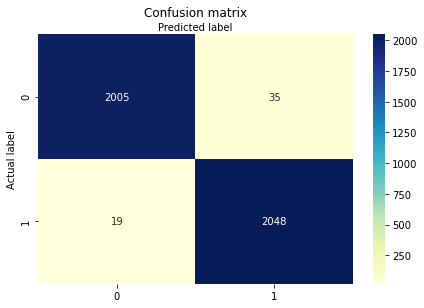

In [42]:
from sklearn.metrics import classification_report, confusion_matrix

#Plotting confusion matrix
cnf_matrix= confusion_matrix(y_test,predictions)

class_names = [0,1]
fig,ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks,class_names)
plt.yticks(tick_marks,class_names)

#create a heat map
sns.heatmap(pd.DataFrame(cnf_matrix), annot = True, cmap = 'YlGnBu',fmt = 'g')
ax.xaxis.set_label_position('top')
plt.tight_layout()
plt.title('Confusion matrix', y = 1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
print('Accuracy Score: ',accuracy_score(y_test,predictions))
plt.show()

* Without tuning Random Forest perform good on sample data. 
* With 98.68% of accuracy RF has shown and there are very few false negatives.
* let's tuning RF model and try to achive more accuracy and try to minimize the false negatives.

Accuracy Score:  0.9885561236912588


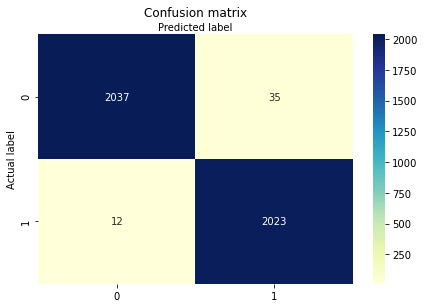

In [43]:
#With Hyper Parameters Tuning
rfc = RandomForestClassifier(criterion = 'gini', n_estimators = 100, random_state = 0)

np.random.seed(7)
# Train/Test split
X_train, X_test, y_train, y_test = train_test_split(X_undersample, y_undersample, random_state=0)

#learning
rfc.fit(X_train,y_train)
#Prediction
predictions=rfc.predict(X_test)

#Plotting confusion matrix
cnf_matrix= confusion_matrix(y_test,predictions)

class_names = [0,1]
fig,ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks,class_names)
plt.yticks(tick_marks,class_names)

#create a heat map
sns.heatmap(pd.DataFrame(cnf_matrix), annot = True, cmap = 'YlGnBu',fmt = 'g')
ax.xaxis.set_label_position('top')
plt.tight_layout()
plt.title('Confusion matrix', y = 1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
print('Accuracy Score: ',accuracy_score(y_test,predictions))
plt.show()

* As the confusion matrix shows that Random Forest Classifier perform better after tuning the model.
* We can see that for 19 to 12 the false negatives are decreased and we can consider it as goto model for doing this Fraud Detection.